In [8]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Jul 31 11:42:46 2024

@author: venkatesh
"""

import torch
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
import numpy as np

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [10]:
model_name='ResNet50'

num_classes = 4
# Assuming 3 classes: "NORMAL", "DRUSEN", "DME","CNV"

if(model_name=='mobilenetv2'):
    from models.mobilenet import MobileNet2
    model=MobileNet2(in_channels=1, num_classes=4)
if(model_name=='ResNet50'):
    from models.resnet import ResNet50
    model=ResNet50(num_classes=num_classes, channels=1)    
if(model_name=='ShuffleNet2'):
    from models.ShuffleNet2 import ShuffleNet2
    model=ShuffleNet2(num_classes=num_classes,,num_inp_channels=1)    
if(model_name=='SqueezeNet'):
    from models.SqueezeNet import SqueezeNet
    model=SqueezeNet(num_classes=num_classes,,num_inp_channels=1)

In [11]:
model=model.to(device)


In [12]:
from datetime import datetime
import time

import os
print ('*******************************************************')
start_time=time.time()
experiments_folder="saved_models/"
experiment_name=datetime.now().strftime("%b_%d_%I_%M_%P_")+"_model_"+model_name

directory=experiments_folder+"/"+experiment_name+"/"
print(directory)
print('Model will be saved to  :', directory)

try:
    os.makedirs(directory)
except:
    print('model already existed..........')

*******************************************************
saved_models//Aug_01_12_35_pm__model_ResNet50/
Model will be saved to  : saved_models//Aug_01_12_35_pm__model_ResNet50/
model already existed..........


In [13]:
import torchvision.transforms as transforms

# Define transformations for data augmentation or normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image to required size
    transforms.ToTensor()
])

In [17]:
from dataset import CustomDataset
from torch.utils.data import Dataset, DataLoader

# Create CustomDataset instance
dataset = CustomDataset('./csv_files/data_train.csv', transform=transform)
train_loader = DataLoader(dataset, batch_size=8, shuffle=False)

val_dataset = CustomDataset('./csv_files/data_valid.csv', transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

test_dataset = CustomDataset('./csv_files/test_on_remaining_data.csv', transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print(len(train_loader))
print(len(val_dataloader))

print('number of testing images',len(test_dataset))


2166
271
number of testing images 86648


In [18]:


learning_rate=0.0001
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [19]:
# Train your model
# Train your model
from tqdm import tqdm

# Define your training function
model.train()
train_losses = []  # List to store training losses
val_losses = []  # List to store validaion losses
train_accuracy=[]
validation_accuracy=[]

num_epochs=25



for epoch in range(num_epochs):
    running_loss = 0.0
    validation_loss=0.0
    
    y_true_train = []
    y_pred_train = []


    # Create tqdm progress bar
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch + 1}/{num_epochs}')

    for batch_idx, (images, labels) in progress_bar:
        images = images.to(device)
        labels = labels.to(device)
        #images=images/255
        #print(torch.unique(images))
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        y_pred_train.extend(outputs.detach().argmax(dim=-1).tolist())
        y_true_train.extend(labels.detach().tolist())

        
        # Update progress bar description with current loss
        progress_bar.set_postfix({'Loss': running_loss / (batch_idx + 1)})

        
    total_correct = len([True for x, y in zip(y_pred_train, y_true_train) if x==y])
    total = len(y_pred_train)
    accuracy = total_correct * 100 / total
    train_accuracy.append(accuracy)

    print("-------------------------------------------------")
    print("Epoch: {} Train mean loss: {:.8f}".format(epoch, running_loss))
    print("Train Accuracy%: ", accuracy, "==", total_correct, "/", total)
    print("-------------------------------------------------")
        
    save_path=directory+'/mymodel_'+str(epoch)+'.pth'
    torch.save(model.state_dict(), save_path)
    print(f'Model saved at: {save_path}')

    # storing the train losses
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    progress_bar = tqdm(enumerate(val_dataloader), total=len(val_dataloader), desc=f'Epoch {epoch + 1}/{num_epochs}')

    y_true_val = []
    y_pred_val = []

    
    model.eval()
    for batch_idx, (images, labels) in progress_bar:
        images = images.to(device)
        labels = labels.to(device)
        #images=images/255
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        validation_loss += loss.item()

        y_pred_val.extend(outputs.detach().argmax(dim=-1).tolist())
        y_true_val.extend(labels.detach().tolist())

        
        
        # Update progress bar description with current loss
        progress_bar.set_postfix({'Validation Loss': validation_loss / (batch_idx + 1)})

    # storing the validation losses

    epoch_loss = validation_loss / len(val_dataloader)
    val_losses.append(epoch_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')
    
    total_correct = len([True for x, y in zip(y_pred_val, y_true_val) if x==y])
    total = len(y_true_val)
    accuracy = total_correct * 100 / total
    validation_accuracy.append(accuracy)

    print("-------------------------------------------------")
    print("Epoch: {} Val mean loss: {:.8f}".format(epoch, validation_loss))
    print("valiation Accuracy%: ", accuracy, "==", total_correct, "/", total)
    print("-------------------------------------------------")

    import pandas as pd

    loss_dic={"training_loss":train_losses,
              "val_loss":val_losses,
              "train_accuracy":train_accuracy,
              "validation_accuracy":validation_accuracy}

    df = pd.DataFrame.from_dict(loss_dic) 
    path=directory+'/loss.csv'
    df.to_csv (path, index = False, header=True)

Epoch 1/25: 100%|██████████| 2166/2166 [02:37<00:00, 13.72it/s, Loss=0.574]


-------------------------------------------------
Epoch: 0 Train mean loss: 1242.45223141
Train Accuracy%:  80.88065558633426 == 14015 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_12_35_pm__model_ResNet50//mymodel_0.pth
Epoch [1/25], Loss: 0.5736


Epoch 1/25: 100%|██████████| 271/271 [00:10<00:00, 24.66it/s, Validation Loss=0.366]


Epoch [1/25], Loss: 0.3663
-------------------------------------------------
Epoch: 0 Val mean loss: 99.26889135
valiation Accuracy%:  88.87863405629903 == 1926 / 2167
-------------------------------------------------


Epoch 2/25: 100%|██████████| 2166/2166 [02:37<00:00, 13.79it/s, Loss=0.462]


-------------------------------------------------
Epoch: 1 Train mean loss: 1000.62998792
Train Accuracy%:  85.1281163434903 == 14751 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_12_35_pm__model_ResNet50//mymodel_1.pth
Epoch [2/25], Loss: 0.4620


Epoch 2/25: 100%|██████████| 271/271 [00:10<00:00, 25.60it/s, Validation Loss=0.358]


Epoch [2/25], Loss: 0.3584
-------------------------------------------------
Epoch: 1 Val mean loss: 97.12027287
valiation Accuracy%:  87.4942316566682 == 1896 / 2167
-------------------------------------------------


Epoch 3/25: 100%|██████████| 2166/2166 [02:35<00:00, 13.95it/s, Loss=0.326]


-------------------------------------------------
Epoch: 2 Train mean loss: 705.27906538
Train Accuracy%:  89.45060018467221 == 15500 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_12_35_pm__model_ResNet50//mymodel_2.pth
Epoch [3/25], Loss: 0.3256


Epoch 3/25: 100%|██████████| 271/271 [00:10<00:00, 25.40it/s, Validation Loss=0.253]


Epoch [3/25], Loss: 0.2529
-------------------------------------------------
Epoch: 2 Val mean loss: 68.53443560
valiation Accuracy%:  91.23211813567144 == 1977 / 2167
-------------------------------------------------


Epoch 4/25: 100%|██████████| 2166/2166 [02:35<00:00, 13.91it/s, Loss=0.266]


-------------------------------------------------
Epoch: 3 Train mean loss: 575.73428684
Train Accuracy%:  91.47045244690673 == 15850 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_12_35_pm__model_ResNet50//mymodel_3.pth
Epoch [4/25], Loss: 0.2658


Epoch 4/25: 100%|██████████| 271/271 [00:10<00:00, 25.19it/s, Validation Loss=0.268]


Epoch [4/25], Loss: 0.2677
-------------------------------------------------
Epoch: 3 Val mean loss: 72.54724829
valiation Accuracy%:  91.09367789570835 == 1974 / 2167
-------------------------------------------------


Epoch 5/25: 100%|██████████| 2166/2166 [02:36<00:00, 13.81it/s, Loss=0.213]


-------------------------------------------------
Epoch: 4 Train mean loss: 461.36653053
Train Accuracy%:  93.28831948291783 == 16165 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_12_35_pm__model_ResNet50//mymodel_4.pth
Epoch [5/25], Loss: 0.2130


Epoch 5/25: 100%|██████████| 271/271 [00:10<00:00, 25.04it/s, Validation Loss=0.216]


Epoch [5/25], Loss: 0.2164
-------------------------------------------------
Epoch: 4 Val mean loss: 58.63685906
valiation Accuracy%:  93.77018920166128 == 2032 / 2167
-------------------------------------------------


Epoch 6/25: 100%|██████████| 2166/2166 [02:37<00:00, 13.76it/s, Loss=0.193]


-------------------------------------------------
Epoch: 5 Train mean loss: 418.22141033
Train Accuracy%:  93.84233610341643 == 16261 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_12_35_pm__model_ResNet50//mymodel_5.pth
Epoch [6/25], Loss: 0.1931


Epoch 6/25: 100%|██████████| 271/271 [00:10<00:00, 25.18it/s, Validation Loss=0.218]


Epoch [6/25], Loss: 0.2175
-------------------------------------------------
Epoch: 5 Val mean loss: 58.95534390
valiation Accuracy%:  92.89340101522842 == 2013 / 2167
-------------------------------------------------


Epoch 7/25: 100%|██████████| 2166/2166 [02:36<00:00, 13.84it/s, Loss=0.167]


-------------------------------------------------
Epoch: 6 Train mean loss: 361.93328275
Train Accuracy%:  94.82340720221606 == 16431 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_12_35_pm__model_ResNet50//mymodel_6.pth
Epoch [7/25], Loss: 0.1671


Epoch 7/25: 100%|██████████| 271/271 [00:10<00:00, 25.29it/s, Validation Loss=0.198]


Epoch [7/25], Loss: 0.1978
-------------------------------------------------
Epoch: 6 Val mean loss: 53.61226473
valiation Accuracy%:  93.21642824180896 == 2020 / 2167
-------------------------------------------------


Epoch 8/25: 100%|██████████| 2166/2166 [02:37<00:00, 13.76it/s, Loss=0.147]


-------------------------------------------------
Epoch: 7 Train mean loss: 317.46865563
Train Accuracy%:  95.30240073868883 == 16514 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_12_35_pm__model_ResNet50//mymodel_7.pth
Epoch [8/25], Loss: 0.1466


Epoch 8/25: 100%|██████████| 271/271 [00:10<00:00, 24.90it/s, Validation Loss=0.179]


Epoch [8/25], Loss: 0.1788
-------------------------------------------------
Epoch: 7 Val mean loss: 48.46684537
valiation Accuracy%:  94.23165666820489 == 2042 / 2167
-------------------------------------------------


Epoch 9/25: 100%|██████████| 2166/2166 [02:36<00:00, 13.85it/s, Loss=0.131]


-------------------------------------------------
Epoch: 8 Train mean loss: 283.79258779
Train Accuracy%:  95.86218836565097 == 16611 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_12_35_pm__model_ResNet50//mymodel_8.pth
Epoch [9/25], Loss: 0.1310


Epoch 9/25: 100%|██████████| 271/271 [00:10<00:00, 24.89it/s, Validation Loss=0.195]


Epoch [9/25], Loss: 0.1949
-------------------------------------------------
Epoch: 8 Val mean loss: 52.80735283
valiation Accuracy%:  93.26257498846331 == 2021 / 2167
-------------------------------------------------


Epoch 10/25: 100%|██████████| 2166/2166 [02:36<00:00, 13.84it/s, Loss=0.115]


-------------------------------------------------
Epoch: 9 Train mean loss: 249.07476110
Train Accuracy%:  96.2719298245614 == 16682 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_12_35_pm__model_ResNet50//mymodel_9.pth
Epoch [10/25], Loss: 0.1150


Epoch 10/25: 100%|██████████| 271/271 [00:10<00:00, 25.09it/s, Validation Loss=0.218]


Epoch [10/25], Loss: 0.2176
-------------------------------------------------
Epoch: 9 Val mean loss: 58.98001062
valiation Accuracy%:  92.66266728195662 == 2008 / 2167
-------------------------------------------------


Epoch 11/25: 100%|██████████| 2166/2166 [02:36<00:00, 13.87it/s, Loss=0.106]


-------------------------------------------------
Epoch: 10 Train mean loss: 230.20934766
Train Accuracy%:  96.47968605724839 == 16718 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_12_35_pm__model_ResNet50//mymodel_10.pth
Epoch [11/25], Loss: 0.1063


Epoch 11/25: 100%|██████████| 271/271 [00:10<00:00, 25.21it/s, Validation Loss=0.209]


Epoch [11/25], Loss: 0.2087
-------------------------------------------------
Epoch: 10 Val mean loss: 56.55458061
valiation Accuracy%:  93.63174896169821 == 2029 / 2167
-------------------------------------------------


Epoch 12/25: 100%|██████████| 2166/2166 [02:36<00:00, 13.83it/s, Loss=0.0969]


-------------------------------------------------
Epoch: 11 Train mean loss: 209.77889129
Train Accuracy%:  96.76246537396122 == 16767 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_12_35_pm__model_ResNet50//mymodel_11.pth
Epoch [12/25], Loss: 0.0969


Epoch 12/25: 100%|██████████| 271/271 [00:10<00:00, 25.28it/s, Validation Loss=0.211]


Epoch [12/25], Loss: 0.2110
-------------------------------------------------
Epoch: 11 Val mean loss: 57.17126111
valiation Accuracy%:  93.63174896169821 == 2029 / 2167
-------------------------------------------------


Epoch 13/25: 100%|██████████| 2166/2166 [02:36<00:00, 13.87it/s, Loss=0.0884]


-------------------------------------------------
Epoch: 12 Train mean loss: 191.47391085
Train Accuracy%:  97.27608494921515 == 16856 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_12_35_pm__model_ResNet50//mymodel_12.pth
Epoch [13/25], Loss: 0.0884


Epoch 13/25: 100%|██████████| 271/271 [00:10<00:00, 24.95it/s, Validation Loss=0.214]


Epoch [13/25], Loss: 0.2136
-------------------------------------------------
Epoch: 12 Val mean loss: 57.87792700
valiation Accuracy%:  93.72404245500692 == 2031 / 2167
-------------------------------------------------


Epoch 14/25: 100%|██████████| 2166/2166 [02:36<00:00, 13.88it/s, Loss=0.0776]


-------------------------------------------------
Epoch: 13 Train mean loss: 168.12645592
Train Accuracy%:  97.2876269621422 == 16858 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_12_35_pm__model_ResNet50//mymodel_13.pth
Epoch [14/25], Loss: 0.0776


Epoch 14/25: 100%|██████████| 271/271 [00:10<00:00, 25.12it/s, Validation Loss=0.192]


Epoch [14/25], Loss: 0.1919
-------------------------------------------------
Epoch: 13 Val mean loss: 52.00290390
valiation Accuracy%:  94.13936317489618 == 2040 / 2167
-------------------------------------------------


Epoch 15/25: 100%|██████████| 2166/2166 [02:36<00:00, 13.87it/s, Loss=0.0724]


-------------------------------------------------
Epoch: 14 Train mean loss: 156.76279618
Train Accuracy%:  97.59349030470914 == 16911 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_12_35_pm__model_ResNet50//mymodel_14.pth
Epoch [15/25], Loss: 0.0724


Epoch 15/25: 100%|██████████| 271/271 [00:10<00:00, 24.76it/s, Validation Loss=0.227]


Epoch [15/25], Loss: 0.2272
-------------------------------------------------
Epoch: 14 Val mean loss: 61.57832713
valiation Accuracy%:  93.77018920166128 == 2032 / 2167
-------------------------------------------------


Epoch 16/25: 100%|██████████| 2166/2166 [02:33<00:00, 14.10it/s, Loss=0.0685]


-------------------------------------------------
Epoch: 15 Train mean loss: 148.47455080
Train Accuracy%:  97.85318559556787 == 16956 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_12_35_pm__model_ResNet50//mymodel_15.pth
Epoch [16/25], Loss: 0.0685


Epoch 16/25: 100%|██████████| 271/271 [00:10<00:00, 25.26it/s, Validation Loss=0.223]


Epoch [16/25], Loss: 0.2235
-------------------------------------------------
Epoch: 15 Val mean loss: 60.56264519
valiation Accuracy%:  93.53945546838948 == 2027 / 2167
-------------------------------------------------


Epoch 17/25: 100%|██████████| 2166/2166 [02:36<00:00, 13.87it/s, Loss=0.059] 


-------------------------------------------------
Epoch: 16 Train mean loss: 127.81475887
Train Accuracy%:  98.02631578947368 == 16986 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_12_35_pm__model_ResNet50//mymodel_16.pth
Epoch [17/25], Loss: 0.0590


Epoch 17/25: 100%|██████████| 271/271 [00:10<00:00, 24.95it/s, Validation Loss=0.27] 


Epoch [17/25], Loss: 0.2696
-------------------------------------------------
Epoch: 16 Val mean loss: 73.06202726
valiation Accuracy%:  92.70881402861099 == 2009 / 2167
-------------------------------------------------


Epoch 18/25: 100%|██████████| 2166/2166 [02:35<00:00, 13.93it/s, Loss=0.0621]


-------------------------------------------------
Epoch: 17 Train mean loss: 134.40887272
Train Accuracy%:  98.00323176361958 == 16982 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_12_35_pm__model_ResNet50//mymodel_17.pth
Epoch [18/25], Loss: 0.0621


Epoch 18/25: 100%|██████████| 271/271 [00:10<00:00, 25.65it/s, Validation Loss=0.188]


Epoch [18/25], Loss: 0.1883
-------------------------------------------------
Epoch: 17 Val mean loss: 51.01715760
valiation Accuracy%:  94.32395016151361 == 2044 / 2167
-------------------------------------------------


Epoch 19/25: 100%|██████████| 2166/2166 [02:34<00:00, 14.03it/s, Loss=0.0557]


-------------------------------------------------
Epoch: 18 Train mean loss: 120.54591259
Train Accuracy%:  98.26869806094183 == 17028 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_12_35_pm__model_ResNet50//mymodel_18.pth
Epoch [19/25], Loss: 0.0557


Epoch 19/25: 100%|██████████| 271/271 [00:10<00:00, 25.21it/s, Validation Loss=0.259]


Epoch [19/25], Loss: 0.2594
-------------------------------------------------
Epoch: 18 Val mean loss: 70.29952920
valiation Accuracy%:  93.58560221504383 == 2028 / 2167
-------------------------------------------------


Epoch 20/25: 100%|██████████| 2166/2166 [02:36<00:00, 13.86it/s, Loss=0.0518]


-------------------------------------------------
Epoch: 19 Train mean loss: 112.25698346
Train Accuracy%:  98.29178208679593 == 17032 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_12_35_pm__model_ResNet50//mymodel_19.pth
Epoch [20/25], Loss: 0.0518


Epoch 20/25: 100%|██████████| 271/271 [00:10<00:00, 25.34it/s, Validation Loss=0.256]


Epoch [20/25], Loss: 0.2558
-------------------------------------------------
Epoch: 19 Val mean loss: 69.31590382
valiation Accuracy%:  94.60083064143979 == 2050 / 2167
-------------------------------------------------


Epoch 21/25: 100%|██████████| 2166/2166 [02:35<00:00, 13.89it/s, Loss=0.0502]


-------------------------------------------------
Epoch: 20 Train mean loss: 108.65941856
Train Accuracy%:  98.47068328716529 == 17063 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_12_35_pm__model_ResNet50//mymodel_20.pth
Epoch [21/25], Loss: 0.0502


Epoch 21/25: 100%|██████████| 271/271 [00:10<00:00, 25.01it/s, Validation Loss=0.2]  


Epoch [21/25], Loss: 0.2000
-------------------------------------------------
Epoch: 20 Val mean loss: 54.20315486
valiation Accuracy%:  94.83156437471158 == 2055 / 2167
-------------------------------------------------


Epoch 22/25: 100%|██████████| 2166/2166 [02:35<00:00, 13.90it/s, Loss=0.0555]


-------------------------------------------------
Epoch: 21 Train mean loss: 120.23942400
Train Accuracy%:  98.28601108033241 == 17031 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_12_35_pm__model_ResNet50//mymodel_21.pth
Epoch [22/25], Loss: 0.0555


Epoch 22/25: 100%|██████████| 271/271 [00:10<00:00, 25.03it/s, Validation Loss=0.222]


Epoch [22/25], Loss: 0.2220
-------------------------------------------------
Epoch: 21 Val mean loss: 60.16802186
valiation Accuracy%:  94.50853714813105 == 2048 / 2167
-------------------------------------------------


Epoch 23/25: 100%|██████████| 2166/2166 [02:35<00:00, 13.89it/s, Loss=0.0436]


-------------------------------------------------
Epoch: 22 Train mean loss: 94.43703619
Train Accuracy%:  98.57456140350877 == 17081 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_12_35_pm__model_ResNet50//mymodel_22.pth
Epoch [23/25], Loss: 0.0436


Epoch 23/25: 100%|██████████| 271/271 [00:10<00:00, 25.27it/s, Validation Loss=0.23] 


Epoch [23/25], Loss: 0.2299
-------------------------------------------------
Epoch: 22 Val mean loss: 62.29148435
valiation Accuracy%:  95.29303184125519 == 2065 / 2167
-------------------------------------------------


Epoch 24/25: 100%|██████████| 2166/2166 [02:35<00:00, 13.90it/s, Loss=0.0445]


-------------------------------------------------
Epoch: 23 Train mean loss: 96.37899987
Train Accuracy%:  98.61495844875347 == 17088 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_12_35_pm__model_ResNet50//mymodel_23.pth
Epoch [24/25], Loss: 0.0445


Epoch 24/25: 100%|██████████| 271/271 [00:10<00:00, 25.02it/s, Validation Loss=0.314]


Epoch [24/25], Loss: 0.3143
-------------------------------------------------
Epoch: 23 Val mean loss: 85.18446741
valiation Accuracy%:  93.30872173511767 == 2022 / 2167
-------------------------------------------------


Epoch 25/25: 100%|██████████| 2166/2166 [02:36<00:00, 13.87it/s, Loss=0.0418]


-------------------------------------------------
Epoch: 24 Train mean loss: 90.57827786
Train Accuracy%:  98.64958448753463 == 17094 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_12_35_pm__model_ResNet50//mymodel_24.pth
Epoch [25/25], Loss: 0.0418


Epoch 25/25: 100%|██████████| 271/271 [00:10<00:00, 25.35it/s, Validation Loss=0.222]

Epoch [25/25], Loss: 0.2225
-------------------------------------------------
Epoch: 24 Val mean loss: 60.29625526
valiation Accuracy%:  94.37009690816798 == 2045 / 2167
-------------------------------------------------


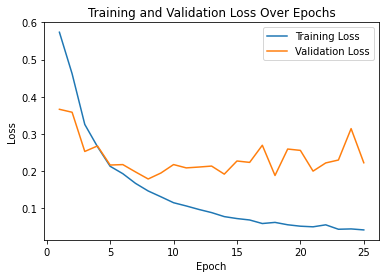

In [20]:
import matplotlib.pyplot as plt

# Plot training and validation losses
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

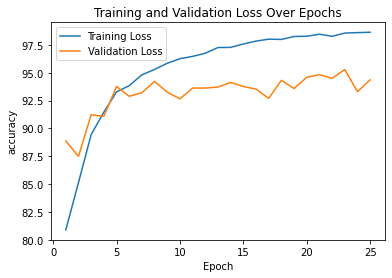

In [27]:
import matplotlib.pyplot as plt

# Plot training and validation accuracies
plt.plot(range(1, train_accuracyn_accuracy) + 1), train_accuracy, label='Training Loss')
plt.plot(range(1, len(validation_accuracy) + 1), validation_accuracy, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('Training and Validation accuracies Over Epochs')
plt.legend()
plt.show()

# Model Analysis

In [21]:
from torchsummary import summary

summary(model, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           3,136
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,160
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,928
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,640
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,640
      BatchNorm2d-14          [-1, 256,

In [22]:
import re
from ptflops import get_model_complexity_info
from pthflops import count_ops

macs, params = get_model_complexity_info(model, (1, 224,224), as_strings=True,print_per_layer_stat=False, verbose=False)
# # Extract the numerical value
flops = eval(re.findall(r'([\d.]+)', macs)[0])*2
# Extract the unit
flops_unit = re.findall(r'([A-Za-z]+)', macs)[0][0]

print('Computational complexity: {:<8}'.format(macs))
print('Computational complexity: {} {}Flops'.format(flops, flops_unit))
print('Number of parameters: {:<8}'.format(params))

Computational complexity: 4.06 GMac
Computational complexity: 8.12 GFlops
Number of parameters: 23.54 M 


# Testing 

In [23]:
# choosing the best model from validation loss.

best_epoch=np.argmin(val_losses)
print('best_epoch:',best_epoch)

best_epoch: 7


In [24]:
ckpt = torch.load(directory+'/mymodel_'+str(best_epoch)+'.pth')
model.load_state_dict(ckpt)
model.eval()


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (max_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (batch_norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (i_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, m

In [25]:
test_dataset = CustomDataset('./csv_files/test_on_remaining_data.csv', transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print(len(test_dataloader))


10831


In [26]:
from tqdm import tqdm

progress_bar = tqdm(enumerate(test_dataloader), total=len(test_dataloader), desc=f'testing')

y_true_val = []
y_pred_val = []


model.eval()
for batch_idx, (images, labels) in progress_bar:
    images = images.to(device)
    labels = labels.to(device)
    #images=images/255
    optimizer.zero_grad()

    outputs = model(images)

    y_pred_val.extend(outputs.detach().argmax(dim=-1).tolist())
    y_true_val.extend(labels.detach().tolist())



    # Update progress bar description with current loss



total_correct = len([True for x, y in zip(y_pred_val, y_true_val) if x==y])
total = len(y_true_val)
accuracy = total_correct * 100 / total

print("-------------------------------------------------")
print("TEST Accuracy (%): ", accuracy, "==", total_correct, "/", total)
print("-------------------------------------------------")


testing: 100%|██████████| 10831/10831 [07:02<00:00, 25.62it/s]

-------------------------------------------------
TEST Accuracy (%):  93.99986150863263 == 81449 / 86648
-------------------------------------------------


# Demo on Test data

[0, 3, 3, 1, 0, 0, 2, 3]
tensor([0, 3, 3, 0, 0, 0, 2, 1])


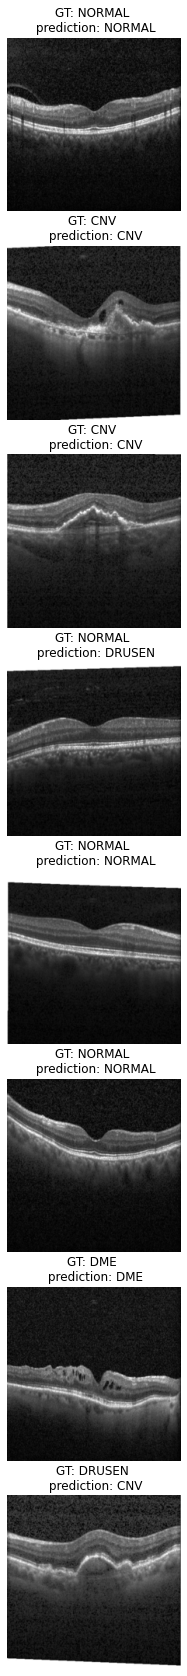

In [34]:
import matplotlib.pyplot as plt

test_dataset = CustomDataset('./csv_files/test_on_remaining_data.csv', transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True)

int_to_class = {0:"NORMAL" , 1:"DRUSEN", 2:"DME" ,3:"CNV"}  
# Function to show images
def show_images(images, labels,predictions):
    plt.figure(figsize=(30, 30))
    for i in range(len(images)):
        plt.subplot(len(images),1 , i + 1)
        plt.title(f"GT: {int_to_class[labels[i].item()]} \n prediction: {int_to_class[predictions[i]]}")
        plt.imshow(images[i][0], cmap="gray")
        plt.axis('off')
    plt.show()

# Display a batch of images
for images, labels in test_dataloader:
    images = images.to(device)
    outputs = model(images)
    outputs_cpu=outputs.detach().argmax(dim=-1).tolist()
    print(outputs_cpu)
    print(labels)
    
    break  # Show only the first batch
    
    
images=images.to('cpu')
    
show_images(images,labels,outputs_cpu)